# Group Classifier Validation

Validate saved group-classifier predictions using parquet outputs and truth labels from the main data files.

This notebook does **not** run model inference.


In [1]:
import torch
import numpy as np
import polars as pl
from pathlib import Path
from datetime import datetime

from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.common.evaluation.plots import (
    plot_multilabel_confusion_matrix,
    plot_roc_curves,
    plot_precision_recall_curves,
    plot_probability_distributions,
    plot_confidence_analysis,
)

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

print(f"Project root: {PROJECT_ROOT}")


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace


## List Available Prediction Files

Find saved `group_classifier` prediction parquet files.


In [2]:
# List available saved prediction files
prediction_dir = Path(PROJECT_ROOT) / "data" / "group_classifier"
prediction_files = sorted(prediction_dir.glob("*_preds.parquet"))
if not prediction_files:
    raise ValueError(f"No prediction parquet files found in {prediction_dir}")

print(f"Found {len(prediction_files)} prediction file(s).")
for i, p in enumerate(prediction_files[:10]):
    print(f"[{i}] {p.name}")


Found 5 prediction file(s).
[0] ml_output_000_preds.parquet
[1] ml_output_001_preds.parquet
[2] ml_output_002_preds.parquet
[3] ml_output_003_preds.parquet
[4] ml_output_004_preds.parquet


## Prediction Source

Validation uses previously exported prediction parquet files from `data/group_classifier`.


In [3]:
# Validation now loads predictions from parquet files (no model inference run in this notebook)
print("Validation mode: load existing predictions + truth from parquet files.")


Validation mode: load existing predictions + truth from parquet files.


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).


In [4]:
# Load validation parquet inputs
parquet_dir = Path(PROJECT_ROOT) / "data"
parquet_paths = sorted(parquet_dir.glob("ml_output_*.parquet"))

# Example: uncomment to select a smaller subset
parquet_paths = parquet_paths[:1]

parquet_paths = [str(p.resolve()) for p in parquet_paths]
if not parquet_paths:
    raise ValueError(f"No parquet files found in {parquet_dir}")

print(f"Validation files: {len(parquet_paths)}")
for p in parquet_paths:
    print(" -", p)


Validation files: 1
 - /workspace/data/ml_output_000.parquet


## Load Predictions And Truth

Load saved prediction parquet files and reconstruct aligned truth targets from input parquet files.


In [5]:
# Load predictions from saved parquet outputs and build truth labels from main parquet files

def _pick_pred(pred_dir: Path, main_path: Path) -> Path | None:
    candidates = [
        pred_dir / f"{main_path.stem}_preds.parquet",
        pred_dir / f"{main_path.stem}_preds_latest.parquet",
    ]
    for c in candidates:
        if c.exists():
            return c
    return None

prediction_dir = Path(PROJECT_ROOT) / "data" / "group_classifier"
paired = []
for main in parquet_paths:
    pred = _pick_pred(prediction_dir, Path(main))
    if pred is not None:
        paired.append((str(Path(main).resolve()), str(pred.resolve())))

if not paired:
    raise RuntimeError(
        "No aligned main/prediction files found. Run group-classifier inference first."
    )

pred_blocks = []
target_blocks = []
for main_path, pred_path in paired:
    main_flat = (
        pl.scan_parquet(main_path)
        .select(["group_pion_in", "group_muon_in", "group_mip_in"])
        .with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32).alias("row_idx"),
            pl.int_ranges(
                pl.lit(0),
                pl.col("group_pion_in").list.len(),
                dtype=pl.UInt32,
            ).alias("group_idx"),
        )
        .explode(["group_idx", "group_pion_in", "group_muon_in", "group_mip_in"])
        .filter(pl.col("group_idx").is_not_null())
        .select(
            "row_idx",
            "group_idx",
            pl.col("group_pion_in").cast(pl.Float32).alias("target_pion"),
            pl.col("group_muon_in").cast(pl.Float32).alias("target_muon"),
            pl.col("group_mip_in").cast(pl.Float32).alias("target_mip"),
        )
        .collect()
    )

    pred_flat = (
        pl.scan_parquet(pred_path)
        .select(["pred_pion", "pred_muon", "pred_mip"])
        .with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32).alias("row_idx"),
            pl.int_ranges(
                pl.lit(0),
                pl.col("pred_pion").list.len(),
                dtype=pl.UInt32,
            ).alias("group_idx"),
        )
        .explode(["group_idx", "pred_pion", "pred_muon", "pred_mip"])
        .filter(pl.col("group_idx").is_not_null())
        .select(
            "row_idx",
            "group_idx",
            pl.col("pred_pion").cast(pl.Float32),
            pl.col("pred_muon").cast(pl.Float32),
            pl.col("pred_mip").cast(pl.Float32),
        )
        .collect()
    )

    if main_flat.height == 0 and pred_flat.height == 0:
        continue

    joined = main_flat.join(pred_flat, on=["row_idx", "group_idx"], how="inner")
    if joined.height != main_flat.height or joined.height != pred_flat.height:
        raise RuntimeError(
            f"Group alignment mismatch for {main_path} vs {pred_path} "
            f"(truth={main_flat.height}, pred={pred_flat.height}, matched={joined.height})"
        )

    target_blocks.append(joined.select(["target_pion", "target_muon", "target_mip"]).to_numpy())
    pred_blocks.append(joined.select(["pred_pion", "pred_muon", "pred_mip"]).to_numpy())

if not pred_blocks:
    raise RuntimeError("No group predictions found after loading parquet files.")

predictions = torch.from_numpy(np.concatenate(pred_blocks, axis=0).astype(np.float32, copy=False))
targets = torch.from_numpy(np.concatenate(target_blocks, axis=0).astype(np.float32, copy=False))

metrics_latest = prediction_dir / "metrics_latest.json"
export_info = {
    "predictions_paths": [pred for _, pred in paired],
    "metrics_path": str(metrics_latest) if metrics_latest.exists() else None,
}

print("Loaded predictions from parquet files:")
print(f"  Pairs used: {len(paired)}")
print(f"  Predictions shape: {tuple(predictions.shape)}")
print(f"  Targets shape: {tuple(targets.shape)}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print("export:", export_info)


Loaded predictions from parquet files:
  Pairs used: 1
  Predictions shape: (3856, 3)
  Targets shape: (3856, 3)
  Predictions range: [0.0000, 1.0000]
export: {'predictions_paths': ['/workspace/data/group_classifier/ml_output_000_preds.parquet'], 'metrics_path': '/workspace/data/group_classifier/metrics_latest.json'}


## Generate Validation Plots

Create comprehensive evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_classifier"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"group_classifier_{timestamp_str}"

class_names = ["pion", "muon", "mip"]

print(f"Generating validation plots in: {plots_dir}")
print(f"Class names: {class_names}")


Generating validation plots in: /workspace/artifacts/validation_plots/group_classifier
Class names: ['pion', 'muon', 'mip']


### Confusion Matrix

The confusion matrix shows how well the model classifies each particle type. It displays the true labels vs predicted labels in a grid format.

**How to interpret:**
- **Diagonal elements** (top-left to bottom-right): Correct predictions. Higher values indicate better performance for that class.
- **Off-diagonal elements**: Misclassifications. Shows which classes are being confused with each other.
- **Normalized values**: Percentages show the proportion of each true class that was predicted as each class. A perfect classifier would have 100% on the diagonal and 0% elsewhere.
- **Class imbalance**: If one class has many more samples, it may appear to perform better simply due to volume. Check the normalized matrix to see true performance.

**What to look for:**
- High diagonal values indicate good classification
- Off-diagonal patterns reveal systematic confusions


1. Generating confusion matrices...


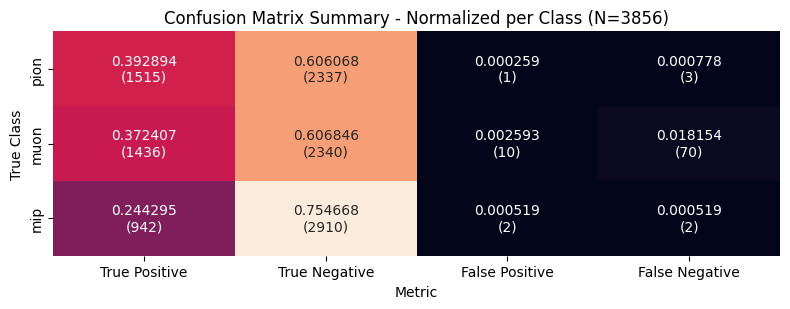

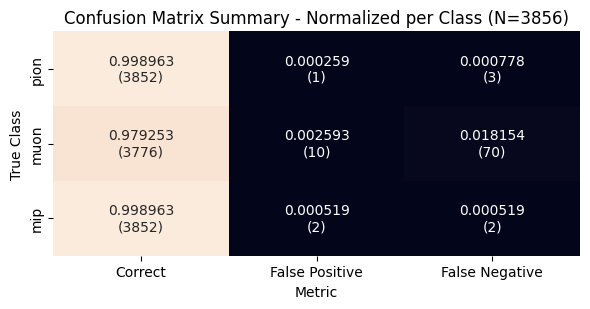

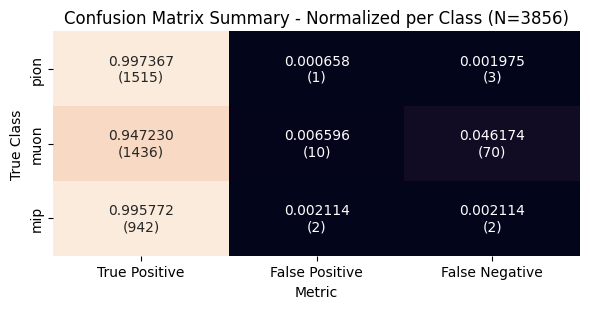

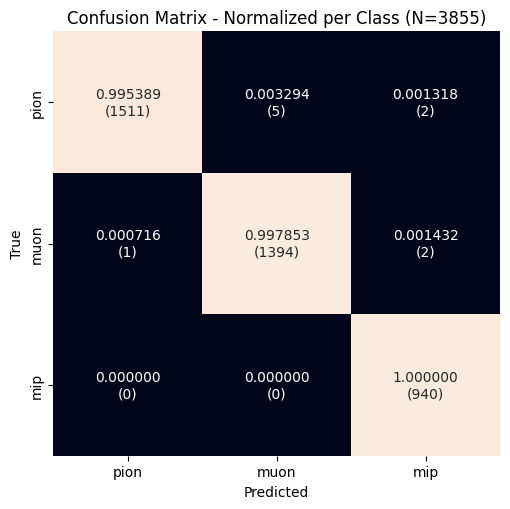

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260218_231305_confusion_matrix_class_normalized.png'

In [7]:
# 1. Confusion Matrix

print("1. Generating confusion matrices...")

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="default",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="correct_mode",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary_correct.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="true_positive_mode",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary_true_positives.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="nxn",
    normalize_mode="row",
    threshold=0.5,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_class_normalized.png",
    show=True,
)


### ROC Curves (Receiver Operating Characteristic)

ROC curves show the trade-off between the true positive rate (sensitivity) and false positive rate (1 - specificity) at different classification thresholds.

**How to interpret:**
- **X-axis (False Positive Rate)**: Proportion of negative samples incorrectly classified as positive. Lower is better.
- **Y-axis (True Positive Rate / Recall)**: Proportion of positive samples correctly identified. Higher is better.
- **Diagonal line (AUC = 0.5)**: Random guessing baseline. Any curve above this indicates the model is learning.
- **AUC (Area Under Curve)**: 
  - AUC = 1.0: Perfect classifier

**What to look for:**
- Curves that hug the top-left corner indicate better performance
- Higher AUC values mean the model can better distinguish between classes
- Compare curves across classes to identify which particle types are easier/harder to classify
- ROC curves are useful when classes are relatively balanced (i.e. ~equally likely to see each class from a random sample)


2. Generating ROC curves...


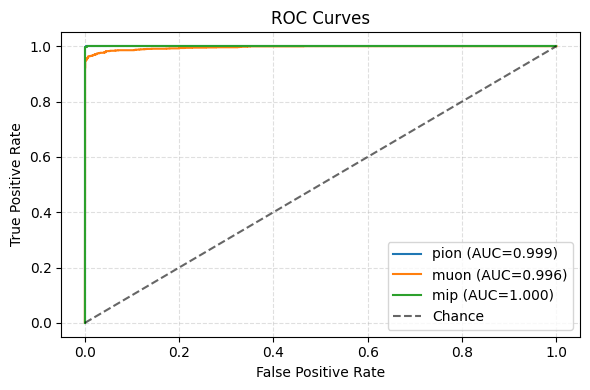

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260218_231305_roc_curves.png'

In [8]:
# 2. ROC Curves
print("2. Generating ROC curves...")
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_roc_curves.png",
    show=True,
)


### Precision-Recall Curves

Precision-Recall curves show the relationship between precision (accuracy of positive predictions) and recall (coverage of positive samples) at different thresholds.

**How to interpret:**
- **X-axis (Recall)**: Proportion of actual positives that were correctly identified. Also called sensitivity or true positive rate.
- **Y-axis (Precision)**: Proportion of predicted positives that are actually positive. Measures prediction quality.
- **AP (Average Precision)**: The area under the PR curve. It's computed by ranking predictions and averaging precision at each recall level, which is mathematically equivalent to integrating the PR curve. Higher values indicate better performance.

**What to look for:**
- Curves that stay high on the Y-axis (high precision) indicate confident, accurate predictions
- Curves that extend far right (high recall) mean the model finds most positive samples
- **Precision-Recall vs ROC**: PR curves are more informative than ROC when classes are imbalanced, as they focus on the positive class performance


3. Generating precision-recall curves...


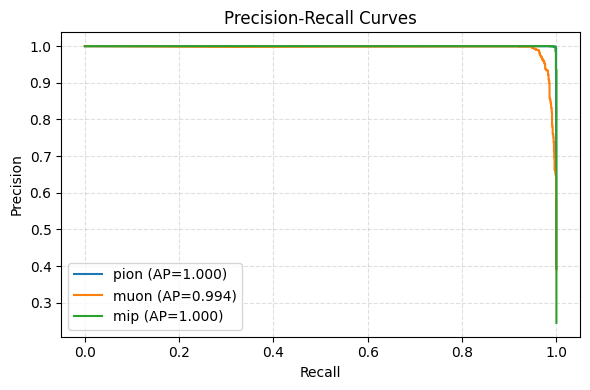

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260218_231305_precision_recall.png'

In [9]:
# 3. Precision-Recall Curves
print("3. Generating precision-recall curves...")
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_precision_recall.png",
    show=True,
)


### Embedding Analysis

Embedding analysis has moved to a dedicated notebook:

`notebooks/validation/group_classification_embeddings.ipynb`

That notebook reconstructs the eager model and extracts **true model embeddings** using `extract_embeddings(...)`.


### Probability Distributions

Show how well separated the probability distributions are for each class. These plots display the predicted probabilities (after softmax) for each particle type.

**How to interpret:**
- **Probability values**: After applying softmax, predictions are converted to probabilities (0-1).
- **Histogram shape**: 
  - Sharp peak near 1.0 for correct class = confident, accurate predictions
  - Broad distribution = uncertain predictions
  - Peak near 0.0 for incorrect classes = good discrimination

**What to look for:**
- Strong peaks at high probability for the correct class indicate confident, accurate predictions
- Low probabilities for incorrect classes show good discrimination


Generating probability and confidence plots...


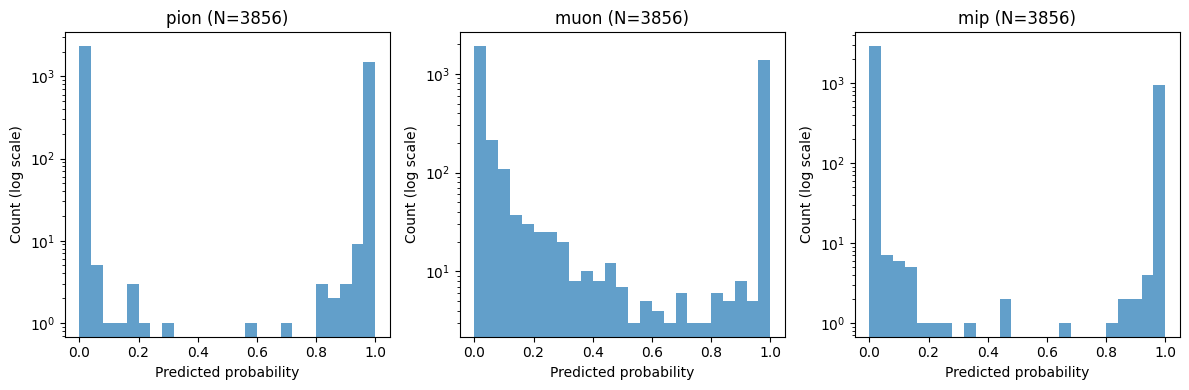

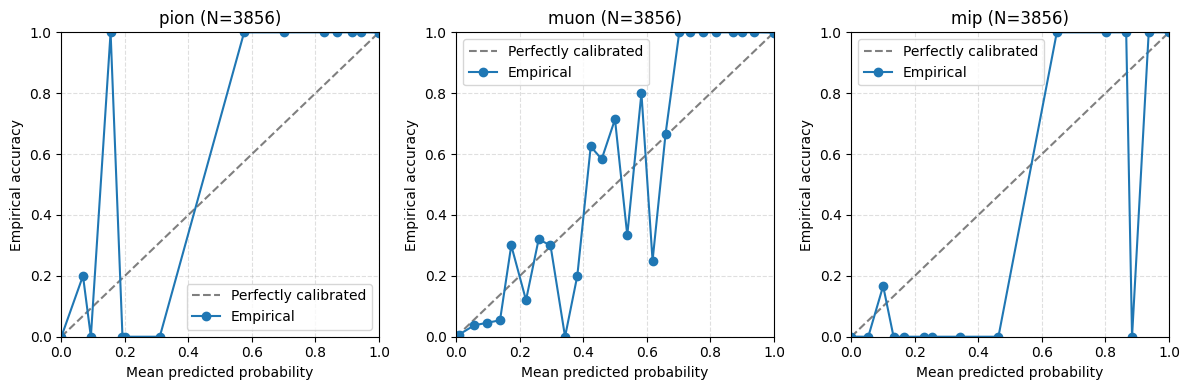

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260218_231305_confidence_analysis.png'

In [10]:
print("Generating probability and confidence plots...")
plot_probability_distributions(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_probability_distributions.png",
    show=True,
)
plot_confidence_analysis(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_confidence_analysis.png",
    show=True,
)


In [11]:
print(f"Saved validation plots to: {plots_dir}")


Saved validation plots to: /workspace/artifacts/validation_plots/group_classifier
